In [1]:
import pandas as pd
import os
import numpy as np
import tqdm
import math
import datetime
import copy

In [2]:
folder = '../CRAFT/results/disambiguation/'
MAX_ITER = 7
no_embedings = []

# Functions

In [3]:
def get_embeding(word,emb):
    return emb.loc[word]

In [4]:
def create_tags_list_dict(row, with_sorting = False):
    # dictionary keyword: list of concepts
    # sorting enabled
    result = {}
    for tag in row:
        key = tag[0].split(',')[0].upper()
        value = tag[1].upper()
        if key in result.keys():
            if  value not in result[key]:
                result[key][value]=1
            else:
                 result[key][value]+=1
        else:
            result[key]= {value:1}
    if with_sorting:
        for key in result.keys():
            d = result[key]
            d = {k:0 for k,v in dict(sorted(d.items(), key=lambda item: item[1], reverse = True)).items()}
            result[key] = d
    else:
        for key in result.keys():
            d = result[key]
            d = {k:0 for k,v in d.items()}
            result[key] = d
        

    return result

In [5]:
def disambiguation(current_selection,embedings, weigths):
    ''' 
    current_selection : dictionary keyword: list of all unique concepts
    weigths: the importance of given keyword
    
    '''
    # we iterate over the current_selection MAX_ITER times
    vis = []
    iterations = dict(zip(current_selection.keys(),[0]*len(current_selection)))
    new_current_selction  = copy.deepcopy(current_selection)
    should_stop = False
    for i in range(MAX_ITER):

        for keyword, concepts_list in new_current_selction.items():
            if iterations[keyword]>0:
                break
            distances = {} # for each possible concept calaculate the mean distance from other kewords (concepts of them)
            for concept in concepts_list.keys():
                distances[concept] = []
                for k, current_best_tags in new_current_selction.items():
                    # foreach keyword that is not a current one 
                    if k!=keyword:
                        current_best_tag = list(current_best_tags.keys())[0] # the first out of list of concepts
                        try:
                            distances[concept].append(weigths[k]*math.dist(get_embeding(concept,embedings),get_embeding(current_best_tag,embedings))) # append distance from this concept
                        except Exception as e:
                            print(e)
                distances[concept] = np.mean(distances[concept]) # mean distance 
            if keyword == 'COFFEE':
                vis.append((i,distances))
            if list(new_current_selction[keyword].values()) == list(dict(sorted(distances.items(), key=lambda item: item[1])).values()):
                iterations[keyword] = i
            new_current_selction[keyword] = dict(sorted(distances.items(), key=lambda item: item[1]))  # upadate the current selection of this keyword
    return new_current_selction,vis, iterations
    

In [6]:
def keywords_importance(grouped_data, tagger_data):
    return grouped_data.reset_index().merge(tagger_data[['PMID','topic_keywords']] ,on = 'PMID').set_index('text_to_annotate')


In [7]:
def get_n_best_tags(data, n = 1):
    return [{k:sorted(v, key=v.get)[:n] for k,v in dd.items()} for dd in data['after_disambiguation']]

In [8]:
def prepare_disambiguation(data, tagger, embedings,column_name = 'ncbo_annotations_pairs' ,  weighting = False, sorting = False, take_best = 1):
    grouped = data.groupby('text_to_annotate').nth(0)
    # get importance for each keyword -> will be used if weighting True
    grouped = keywords_importance(grouped, tagger )
    grouped['possible_tags'] = grouped[column_name].apply(lambda r: create_tags_list_dict(r, sorting))

    # disambiguation
    res = []
    vis = []
    its = []
    for idx, row  in tqdm.tqdm(grouped.iterrows(), total = len(grouped)):
        current_selection = row['possible_tags']
        if not weighting:
            weigths = dict(zip(list(row['topic_keywords'].keys()),[1] * len(row['topic_keywords'])))
        else:
            weigths = row['topic_keywords']
        r,v, it= disambiguation(current_selection, embedings,weigths)
        res.append(r)
        vis.append(v)
        its.append(it)
    grouped['after_disambiguation'] = res
    data = data.merge(grouped['after_disambiguation'].reset_index(), on = 'text_to_annotate' )
    data['disambiguation_best_concept'] = get_n_best_tags(data, take_best)
    return data,vis,its

# Data

In [9]:
def prepare_data(data_name, tagger_name, embedings_name,with_21 = True):
    data = pd.read_csv(data_name)
    data['ncbo_annotations_pairs'] = data['ncbo_annotations_pairs'].apply(eval)
    data['ncbo_annotations_pairs']  = data['ncbo_annotations_pairs'].apply(lambda x : [[a[0].upper(),a[1]] for a in x])
    if with_21:
        data['ncbo_annotations_ST21pv_semtypes_pairs'] = data['ncbo_annotations_ST21pv_semtypes_pairs'].apply(eval)
        data['ncbo_annotations_ST21pv_semtypes_pairs']  = data['ncbo_annotations_ST21pv_semtypes_pairs'].apply(lambda x : [[a[0].upper(),a[1]] for a in x])

    tagger = pd.read_csv(tagger_name)
    tagger['topic_keywords'] = tagger['topic_keywords'].apply(eval).apply(lambda x: {k.upper():v for k,v in dict(x).items()})


    embedings = pd.read_csv(embedings_name)
    embedings = embedings.set_index('words')
    embedings.index = embedings.index.str.upper()
    embedings = embedings[~embedings.index.duplicated(keep='first')]

    return  data, tagger, embedings



## For whole data

In [17]:
data, tagger, embedings = prepare_data( '../CRAFT/results/bertopic_ncbo/bertopic_ncbo_data_2023-01-03_13-27-32.csv', '..//CRAFT/results/bertopic/bertopic_lemmatize_nostopwords_data_2023-01-02_10-04-20.csv',
'..//CRAFT/results/embedings/ncbo_embeddings.csv',False)

In [18]:
data_no_no, vis, its = prepare_disambiguation(data,tagger,embedings,'ncbo_annotations_pairs' )

100%|██████████| 9/9 [00:04<00:00,  1.85it/s]


In [19]:
data_sorting_no_weigth, vis, its = prepare_disambiguation(data,tagger,embedings,'ncbo_annotations_pairs',False, True )

100%|██████████| 9/9 [00:09<00:00,  1.01s/it]


In [20]:
data_sort_weigth, vis, its = prepare_disambiguation(data,tagger,embedings,'ncbo_annotations_pairs',True,True)

100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


In [21]:
now = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")

In [22]:
data_no_no.to_csv(os.path.join(folder,f'bertopic_ncbo_fulldata_lemmatize_nostopwords_data_{now}_no_sorted_no_weighted.csv'))
data_sort_weigth.to_csv(os.path.join(folder,f'bertopic_ncbo_fulldata_lemmatize_nostopwords_data_{now}_weighted_and_sorted.csv'))
data_sorting_no_weigth.to_csv(os.path.join(folder,f'bertopic_ncbo_fulldata_lemmatize_nostopwords_data_{now}_sorted_no_weighted.csv'))

# Analysis

Changes in distances for keyword IMPLANT

In [23]:
# df = pd.DataFrame()
# for i in range(2):
#         df = pd.concat([df,pd.DataFrame.from_dict({i:vis[11][i][1]})], axis = 1)
# #df.to_csv(os.path.join(folder,'changes_in_distances_for_keyword_COFFEE_3rd_topic_train_fine_tunned_21.csv'))

Iterations for each keyword

In [24]:
# its = pd.DataFrame.from_records(its)
# its.to_csv(os.path.join(folder,'number_of_iterations_for_each_keyword_train_ncbo_21.csv'))

Changes in distances for keyword IMPLANT

In [25]:
# df = pd.DataFrame()
# for i in range(4):
#         df = pd.concat([df,pd.DataFrame.from_dict({i:vis[2][i][1]})], axis = 1)
# df.to_csv(os.path.join(folder,'changes_in_distances_for_keyword_IMPLANT_3rd_topic_train_pretrained.csv'))

Iterations for each keyword

In [26]:
# its = pd.DataFrame.from_records(its)
# its.to_csv(os.path.join(folder,'number_of_iterations_for_each_keyword_train_pretrained.csv'))

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
data = pd.read_csv(os.path.join(folder,'number_of_iterations_for_each_keyword_train_pretrained.csv'), index_col = 0)
data = data.fillna(0)

FileNotFoundError: [Errno 2] No such file or directory: '../CRAFT/results/disambiguation/number_of_iterations_for_each_keyword_train_pretrained.csv'

In [ ]:
count = dict(zip([1,2,3,4,5],[0]*5))
for k in count.keys():
    count[k] = sum(np.count_nonzero(np.array(data) == k, axis=1))

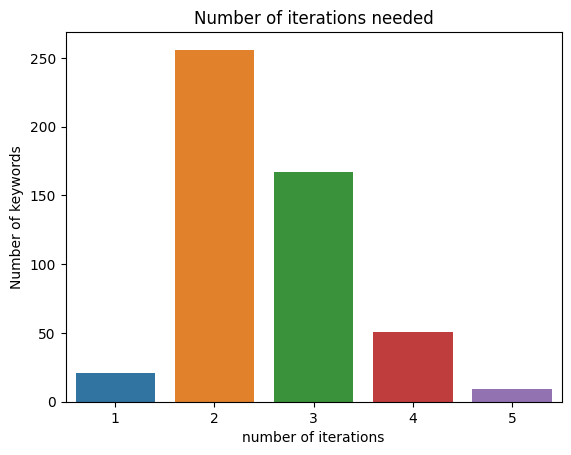

In [ ]:
g = sns.barplot(x = list(count.keys()), y = list(count.values()))
g.set(title = "Number of iterations needed", xlabel= "number of iterations", ylabel = "Number of keywords")
plt.show()

For one keword

In [ ]:
data = pd.read_csv(os.path.join(folder,'changes_in_distances_for_keyword_IMPLANT_3rd_topic_train_pretrained.csv'), index_col = 0)


In [ ]:
data.sort_values(by = '3')

,0,1,2,3
Property or Attribute,12.492491,9.874552,9.359963,9.207696
"Diagnostic, Therapeutic, or Research Equipment",11.902994,10.784446,10.070390,9.537463
Dosage Form by Physical Form,11.568833,9.957484,9.697583,9.659492
Pharmaceutical Dosage Form,11.793626,10.188050,10.236463,10.507468
Implant Dosage Form Category,11.715864,10.079449,10.168648,10.567577
Implant Dosage Form,11.793726,10.284243,10.385307,10.681883
Basic Dosage Form Category,12.009453,10.274202,10.297738,10.722028
Parenteral Route of Administration,12.150218,10.731344,10.759627,10.736739
Medical Device,11.780650,10.267473,10.571644,10.983834
Solid Dose Form Category,12.037037,10.438505,10.645154,11.145570
